In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt

In [3]:
class RSIStrategy:
    
    def __init__(self, data, symbol, data_source, start_date, end_date, window, signal,initial_capital,initial_inventroy,portfolio):
        """
        Consturctor initialization of variables
         Self : Self reference to class
         Data : data frame for price
         sysmbol : Ticker or symbol
         start_date : start date
         end_date : end date
         window : window size for RSI strategy
         signal : signal data frame is to generate signals BUY and SELL respectivaly 
         initial_capital : This is the initial capital used for trading type float
         initial_inventroy : inventory or number of holdings type number
         Portfolio : Data frame
        """
        self.symbol=symbol
        self.data_source=data_source
        self.start_date=start_date
        self.end_date=end_date
        self.window=window
        self.data=data
        self.signal=signal
        self.initial_capital=initial_capital
        self.initial_holding=initial_holding
        self.portfolio=portfolio
        
    def read_date_from_web(self):
        """
        To Read Data from web
        DataReader(name, data_source=None, start=None, end=None, retry_count=3, pause=0.1, session=None, api_key=None)
        Imports data from a number of online sources.
        """
        #web = pdr.DataReader(self.symbol,"yahoo")
        web=pdr.DataReader(self.symbol, self.data_source, start=self.start_date, end=self.end_date)
        #print(web)
        #self.data=pd.DataFrame(web['Adj Close'])
        self.data = web[["Adj Close"]].copy()
        self.data.columns = ["price"]
        print(self.data)
        return self.data
    
    
    def read_data_from_csv(self):
        """
        read data from csv, implement methods
        """
        pass
     
    def RelativeStrenthIndicator(self):
        """
                       100
        RSI = 100 - --------
                 1 + RS

        RS = Average Gain / Average Loss
        
        Period = 14
        
        https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
        
        """
        #calculate the daily difference in price
        self.data['change']=0.0
        self.data['change'] = self.data['price'] - self.data['price'].shift(1)
        #calculate the gain and loss
        self.data['gain'] = np.where(self.data['change']>0,self.data['change'],0 )
        self.data['loss'] = np.where(self.data['change']<0,abs(self.data['change']),0 )
        #calculate the avg_gain  and avg_loss
        self.data['avg_gain'] = self.data['gain'].rolling(window=14).mean()
        self.data['avg_loss'] = self.data['loss'].rolling(window=14).mean()
        self.data.dropna()
        #calulate the RSI using abov formulae
        self.data['rsi'] = 100 - ( 100/(1+(self.data['avg_gain']/self.data['avg_loss'])))
        
        self.data.dropna() #Drop the NAN VALUE        
        print(self.data)
        
        return self.data
        
    def GenerateSignalRSI(self):
        """
        Period =14
        oversold = 30
        overbought = 70
        
        https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
        
        """
        buy_threshold=70
        sell_threshold=30
        
        self.signal = pd.DataFrame(index=self.data.index)
        self.signal['price']=self.data['price'].copy()
        self.signal['RSI']=self.data['rsi'].copy()
        
        self.signal['BUY_SELL_RSI'] = np.where(self.signal['RSI']<30,1,0) #oversold
        self.signal['BUY_SELL_RSI'] = np.where(self.signal['RSI']>70,-1,0) #overbought
        self.signal['BUY_SELL_RSI'] = self.signal['BUY_SELL_RSI'].diff()
        
        print(self.signal)
        
        return self.signal
    
    
    def plotSignalRSI(self):
        """
        Plot Signal
        
        """
        buy_threshold=70
        sell_threshold=30
        
        fig = plt.figure(figsize=(15,25),tight_layout=True)
        sp1 = fig.add_subplot(311)
        sp2 = fig.add_subplot(312)
        sp3 = fig.add_subplot(313)
        #Price plot
        sp1.plot(self.data['price'],label="PRICE")
        sp1.plot(self.data['price'],label="PRICE")
        #Plot the marker or scattered signals pass X and Y for scatter plot
        #currently we have date on X-axis and Price on Y axis.
        sp1.plot(self.signal.loc[self.signal["BUY_SELL_RSI"]== 1].index,self.data[self.signal["BUY_SELL_RSI"]== 1].price,"^",markersize=10,label="B")
        sp1.plot(self.signal.loc[self.signal["BUY_SELL_RSI"]== -1].index,self.data[self.signal["BUY_SELL_RSI"]== -1].price,"v",markersize=10,label="S")
        #RSI Plot
        sp2.plot(self.signal['RSI'],label="RSI")
        sp2.axhline(y= buy_threshold, color = "green", lw = 3.)
        sp2.axhline(y= sell_threshold, color = "red", lw = 3.)
        sp2.axhline(y= (buy_threshold+sell_threshold)/2, color = "blue", lw = 3.)
        sp2.axhline(y= (buy_threshold+sell_threshold)/2, color = "blue", lw = 3.)
        #Zero Line Plot signal plot
        sp3.plot(self.signal["BUY_SELL_RSI"],color='orange',lw=2.)
        
        plt.show()
     
    def RSIInvalidateOrder(self):
        """
        
        To invalidate intermediate orders
        
        """
        buys=[]
        sells=[]
        is_Long=True #Open the Long flag for first trade to buy
  
        holdings=[0] # Holdings 
        cash=[self.initial_capital] #intial cash would be 1000000
        inventory=[0] #number of share
        #Returns=[0]
        buying_capacity=0 #buying capacity of stocks at date.

        for i in range(len(self.signal)):
    
            if self.signal["BUY_SELL_RSI"][i] == 1 and self.initial_capital > 0 and is_Long==True:
                #print("BUY")
                is_Long=False
                buying_capacity=int(self.initial_capital/self.signal["price"][i])
                self.initial_holding = buying_capacity
                holdings.append(self.signal["price"][i] * buying_capacity)
                cash.append(cash[i] - self.signal["price"][i] * buying_capacity)
                inventory.append(buying_capacity)
            
            elif self.signal["BUY_SELL_RSI"][i] == -1 and self.initial_capital > 0 and is_Long==False:
                #print("SELL")
                is_Long=True
                holdings.append(0)
                cash.append(cash[i] + self.signal["price"][i] * buying_capacity)
                inventory.append(0)
        
            else:  
                inventory.append(inventory[i])
                holdings.append(inventory[i] * self.signal.price[i])
                cash.append(cash[i])
                
       
        portfolio_frame = {'cash':cash, 'holdings':holdings, 'inventory':inventory }
        #some issue is here 
        returns = ((cash[-1] + holdings[-1] - cash[0])*100)/cash[0]
        
        portfolio = pd.DataFrame(portfolio_frame)
        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    
        print("Final Portfolio value -", cash[i]+holdings[i],"strategy Return - ",returns,"%")
        
        return portfolio
    

### Class instantiate 

In [4]:
data=pd.DataFrame()
signal=pd.DataFrame()
portfolio=pd.DataFrame()
symbol='BTC-USD' #Bit Coin Symbol
data_source="yahoo"
start_date = "2018-01-01"
end_date = "2022-01-01"
#start_date=dt.datetime(2018,1,1)
#end_date=dt.datetime.today
window=14
initial_capital=1000000
initial_holding=0

algo=RSIStrategy(data,symbol,data_source,start_date,end_date,window,signal,initial_capital,initial_holding,portfolio)
algo.read_date_from_web()


TypeError: string indices must be integers

In [4]:
algo.RelativeStrenthIndicator()

                   price       change         gain         loss    avg_gain  \
Date                                                                          
2017-12-31  14156.400391          NaN     0.000000     0.000000         NaN   
2018-01-01  13657.200195  -499.200195     0.000000   499.200195         NaN   
2018-01-02  14982.099609  1324.899414  1324.899414     0.000000         NaN   
2018-01-03  15201.000000   218.900391   218.900391     0.000000         NaN   
2018-01-04  15599.200195   398.200195   398.200195     0.000000         NaN   
...                  ...          ...          ...          ...         ...   
2021-12-28  47588.855469 -3051.562500     0.000000  3051.562500  552.404297   
2021-12-29  46444.710938 -1144.144531     0.000000  1144.144531  389.255022   
2021-12-30  47178.125000   733.414062   733.414062     0.000000  441.641741   
2021-12-31  46306.445312  -871.679688     0.000000   871.679688  441.641741   
2022-01-01  47686.812500  1380.367188  1380.367188  

,price,change,gain,loss,avg_gain,avg_loss,rsi
Date,,,,,,,
2017-12-31,14156.400391,NaN,0.000000,0.000000,NaN,NaN,NaN
2018-01-01,13657.200195,-499.200195,0.000000,499.200195,NaN,NaN,NaN
2018-01-02,14982.099609,1324.899414,1324.899414,0.000000,NaN,NaN,NaN
2018-01-03,15201.000000,218.900391,218.900391,0.000000,NaN,NaN,NaN
2018-01-04,15599.200195,398.200195,398.200195,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-28,47588.855469,-3051.562500,0.000000,3051.562500,552.404297,482.674107,53.368353
2021-12-29,46444.710938,-1144.144531,0.000000,1144.144531,389.255022,564.398717,40.817228
2021-12-30,47178.125000,733.414062,733.414062,0.000000,441.641741,476.448940,48.104370


In [5]:
#Generate RSI signal

algo.GenerateSignalRSI()

                   price        RSI  BUY_SELL_RSI
Date                                             
2017-12-31  14156.400391        NaN           NaN
2018-01-01  13657.200195        NaN           0.0
2018-01-02  14982.099609        NaN           0.0
2018-01-03  15201.000000        NaN           0.0
2018-01-04  15599.200195        NaN           0.0
...                  ...        ...           ...
2021-12-28  47588.855469  53.368353           0.0
2021-12-29  46444.710938  40.817228           0.0
2021-12-30  47178.125000  48.104370           0.0
2021-12-31  46306.445312  50.425312           0.0
2022-01-01  47686.812500  53.224352           0.0

[1463 rows x 3 columns]


,price,RSI,BUY_SELL_RSI
Date,,,
2017-12-31,14156.400391,NaN,NaN
2018-01-01,13657.200195,NaN,0.0
2018-01-02,14982.099609,NaN,0.0
2018-01-03,15201.000000,NaN,0.0
2018-01-04,15599.200195,NaN,0.0
...,...,...,...
2021-12-28,47588.855469,53.368353,0.0
2021-12-29,46444.710938,40.817228,0.0
2021-12-30,47178.125000,48.104370,0.0


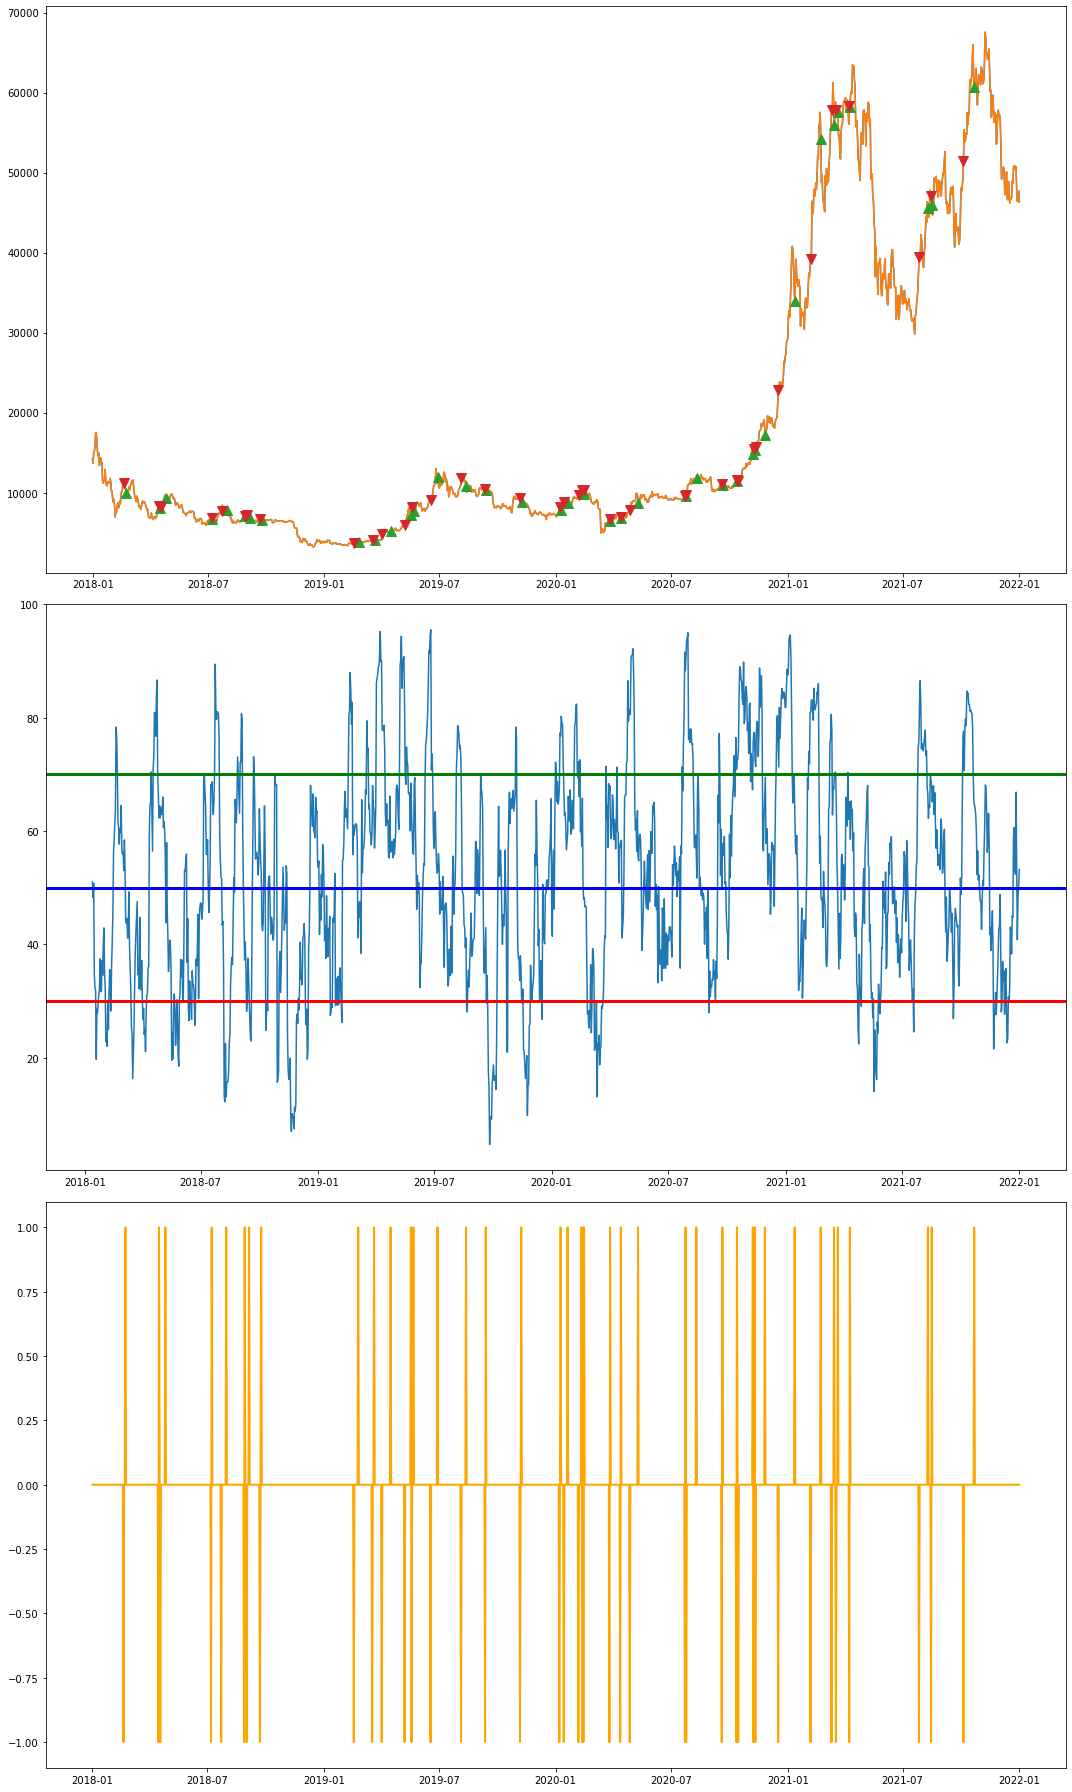

In [6]:
algo.plotSignalRSI()



In [8]:
final_portfolio = algo.RSIInvalidateOrder()

Final Portfolio value - 1227032.3508300781 strategy Return -  24.91182258300781 %


<AxesSubplot:>

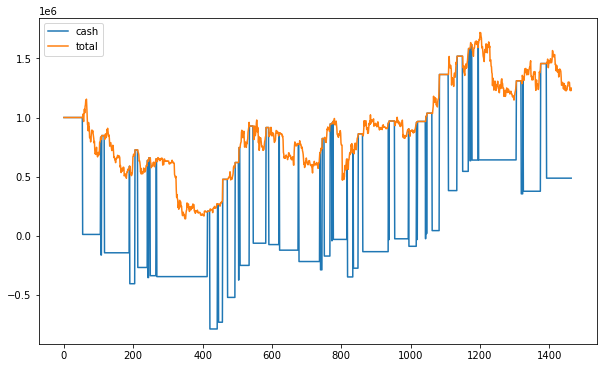

In [12]:
final_portfolio[['cash','total']].plot(figsize = (10,6))